In [60]:
# %load ./scripts/do_RT_thermal.py
from pylab import *
import radmc3dPy as rpy
import numpy as np
import os
from scipy import interpolate
import sys
#sys.path.append('../')
from models import *

In [ ]:
###### if star/wavelength files get overwritten
model = mtest.m
gmaur_spec = np.loadtxt('Spectrum_GM_Aur_corrected.dat',skiprows=3)
wav = gmaur_spec[:,0]
fnu = gmaur_spec[:,1]/(4.*pi*(pc**2))
write_wavelength(model,lam=wav)
write_star(model)
write_spectrum(model, lam_=wav, fnu_=fnu)

In [61]:
p0 = 'default'
outdir = 'out/gmaur/'
pdef = new_model(p0)
pdef['Ms'] = 1.1
pdef['Rs'] = 1.9
pdef['accrate'] = 8e-9
pdef['Ts'] = 4350.0
pdef['nstreams'] = 6
pdef['stream_frac'] = 0.75
pdef['Mdisk'] = 0.2
pdef['Mfrac'] = [0.0005,0.003]
pdef['H0'] = [1,0.2]
pdef['Min'] = 1e-6
pdef['Rdisk'] = [175,175]
pdef['R0'] = [1,1]
pdef['Rc'] = 90
pdef['d2g'] = 0.01
pdef['shock'] = False
pdef['N'] = [300,180,90]
pdef['max'][0] = 300
pdef['min'][0] = 15
pdef['min'][1] = np.radians(45)
pdef['q'] = 0.5
pdef['rho_amb'] = 1e-28
pdef['viscous_heating'] = False
pdef['rho_si'] = 1.675
simdir = 'gmaur_t9/'
pdef = params_from_fargo('/home/akuznetsova/fargo_infall/outputs/'+simdir,par=pdef)

mtest = initialize_model(pdef,outdir=outdir)

stellar_params: {'Ms': 1.1, 'Rs': 1.9, 'Ts': 4350.0, 'accrate': 8e-09, 'f': 0.01}
disk_params: {'Mdisk': 0.2, 'Mfrac': [0.0005, 0.003], 'R0': [1, 1], 'H0': [1, 0.2], 'p': [-1.0, -1.0], 'Rdisk': [175.0, 175.0], 'Tfac': 0.4663489078375602, 'q': 0.5, 'hydro': [0, 0, 0]}
envelope_params: {'Min': 1e-06, 'Rc': 90.0, 'rho_amb': 1e-28, 'rho_0': 3e-22, 'theta_min': 41.810314895778596, 'exf': 0.25, 'Rmax': 15000.0, 'd2g': 0.01, 'shock': False, 'nstreams': 6, 'stream_frac': 0.75}
grid_params: {'N': [300, 180, 90], 'min': [15, 0.7853981633974483, 0], 'max': [300, 1.5707963267948966, 6.283185307179586], 'spacing': ['log', 'lin', 'lin']}
dust_params: {'rho_si': 1.675, 'amin_chem': 0.06, 'amax_ism': 1.0, 'amin': [0.005, 0.005], 'amax': [1, 1000.0], 'apow': [3.5, 3.5]}
RT_params: {'cr_model': 'ssx', 'zetacr': 1.3e-17, 'G0': 1, 'viscous_heating': False, 'fLya': 0.0001}
directory exists - will overwrite current model if you write to it!
Reading amr_grid.inp
Reading wavelength_micron.inp
Assigned model d

In [83]:
def sigma_quick(r,rd):
    return (r)**(-1)*np.exp(-(r/rd))
def m_quick(r,rd,Md,rlim):
    return Md*Msun/(2*pi*np.sum((sigma_quick(r,rd) * (r*AU)*(np.gradient(r)*AU))[r<rlim]))

sd1 = m_quick(mtest.m.r,175,6e-4,300)
sd2 = m_quick(mtest.m.r,175,1e-4,300)
sg = m_quick(mtest.m.r,175,0.09,300)
eps1 = sd1/sg
eps2 = sd2/sg
print(sd1,sd2, sg, eps1, eps2)
print(sg/(1.1*S0conv))

6.573822819402287 1.095637136567048 986.0734229103431 0.006666666666666666 0.0011111111111111113
0.00010085827264998407


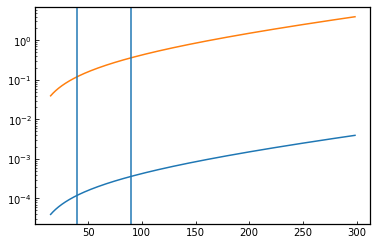

In [82]:
def St(r,Md,rd,a=1,rlim=300):
    sig_g = m_quick(r,rd,Md,rlim)*sigma_quick(r,rd)
    return ((a*1e-4)*(1.675)*pi)/(sig_g*2)

semilogy(mtest.r, St(mtest.r,0.01,175,a=1))
semilogy(mtest.r, St(mtest.r,0.01,175,a=1000))
axvline(40)
axvline(90)

In [62]:

    
disk_from_fargo(mtest.m,'/home/akuznetsova/fargo_infall/outputs/'+simdir,snapshot=20,fluid=0)
disk_from_fargo(mtest.m,'/home/akuznetsova/fargo_infall/outputs/'+simdir,snapshot=20,fluid=1)
disk_from_fargo(mtest.m,'/home/akuznetsova/fargo_infall/outputs/'+simdir,snapshot=20,fluid=2)

0.1993 2052.9058290921985
9.999999999999999e-05 1.0300581179589556
0.0006000000000000001 6.7765373852303386


writing new file:dust_density.inp
thermal monte carlo done!
Reading dust_density.inp
Reading dust_temperature.dat


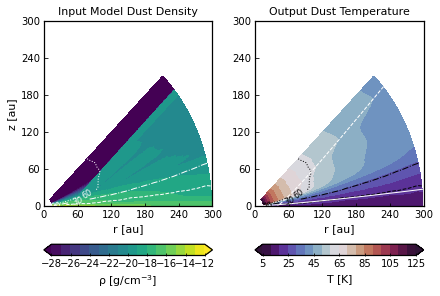

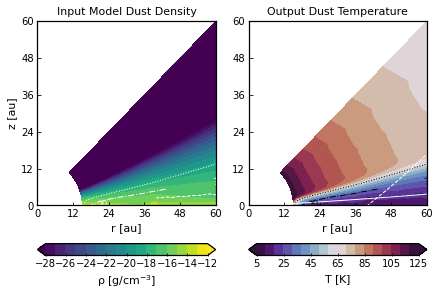

In [63]:
prep_thermal_transfer(mtest,nphot=1000000)
mn = mtest
do_thermal_transfer(mn,nt=64)
print('thermal monte carlo done!')
save_dustRT(mn)

In [6]:
GMaur_params = {'incl': 53.21, 'pa':57.17, 'dpc':159, 'dpc_err': 4}
nu_list = np.array([100,144.98,226,257,283])*1e9
#wavelength of observations in microns
mu_list = 1e4*(c/(nu_list))
print(mu_list)
#fwhm of observations in arcseconds
fwhm_list = np.array([[295,210],[57,35],[130,94],[117,83],[270,162]])*1e-3
#pa of beam in degrees
pa_list = np.array([5.7,-13.8,9.1,-1.5,0.1])
# noise in mJansky/beam
noise_list =np.array([12.4,11.3,16.7,21.9,57.6])*1e-3
obs_params = {'nu': nu_list, 'wav':mu_list, 'fwhm':fwhm_list, 'pa':pa_list,'noise':noise_list}

[2997.92458    2067.81940957 1326.51530088 1166.50761868 1059.33730742]


In [37]:
def beam_area(fwhm):
    return fwhm[0] * fwhm[1] * np.pi / 4. / np.log(2.0)

In [31]:
def snu_units(image,dpc,fwhm,ifreq=0):
    dum_image = image
    data = np.squeeze(image.image[:, ::-1, ifreq].T)
    pixel_area = (image.sizepix_x * image.sizepix_y)/(dpc * pc)**2 * (180./np.pi*3600.)**2
    #beam_area = image.fwhm[0] * image.fwhm[1] * np.pi / 4. / np.log(2.0)
    beam_area = fwhm[0] * fwhm[1] * np.pi / 4. / np.log(2.0)
    data *= (image.sizepix_x * image.sizepix_y / (dpc * pc)**2. * 1e23)
    # Convert data to mJy/beam
    data *= beam_area / pixel_area
    data *= 1e3
    x = image.x / AU #/ dpc
    y = image.y / AU #/ dpc
    return x,y,data

def make_contimage(mu,sizeau=600,npix=300,params={}):
    if params == {}:
        incl = 0
        pa = 0
    else:
        incl = params['incl']
        pa = params['pa']
    command = 'radmc3d image npix {} sizeau {} incl {} lambda {} posang {} secondorder noscat'.format(npix,sizeau,incl,mu,pa)
    os.system(command)
    
def plot_ic_simple():
    im = rpy.image.readImage()
    
def radial_I(fwhm=fwhm,noise=noise,imax=5):
    im = rpy.image.readImage()
    imc = im.imConv(dpc=GMaur_params['dpc'],fwhm=fwhm,pa=pa)
    xau, yau, im_mjy = snu_units(imc,dpc=GMaur_params['dpc'],fwhm=fwhm)
    X,Y = np.meshgrid(xau,yau)
    rau = np.sqrt(X**2 + Y**2)
    rbins = np.arange(1,np.amax(rau),2)
    Ibins = np.linspace(noise/2.,imax,50)
    H,xe,ye = np.histogram2d(rau.flatten(),im_mjy.flatten(),bins=(rbins,Ibins),density=True)
    rr = (rbins[1:] + rbins[:-1])*0.5
    ii = (Ibins[1:] + Ibins[:-1])*0.5
    RR,II = np.meshgrid(rr,ii)
    Ip = np.sum(II*H.T,axis=0)/np.sum(H.T,axis=0)
    return (rr,Ip)

[0.23270440251572327, 0.23270440251572327]
Reading image.out


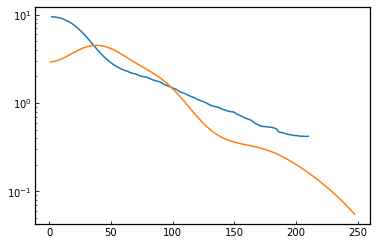

In [41]:
fwhm = [37/GMaur_params['dpc'],37/GMaur_params['dpc']]
beam_conv = beam_area(fwhm)/beam_area(fwhm_list[j])
noise= noise_list[j]/beam_conv
pa = 0.0
plot(*radial_I(imax=10,fwhm=fwhm,noise=noise))
plot(gma_data['R'],gma_data['I150']*1e3)
yscale('log')

In [10]:
j = 2
make_contimage(mu = mu_list[j])

Reading image.out


<ipython-input-14-54f277ebacf7>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(xau, yau, im_mjy,cmap='magma')


(-150.0, 150.0)

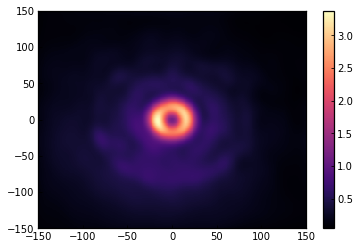

In [14]:
f,ax = subplots(1)
fwhm = fwhm_list[j]
pa = pa_list[j]
im = rpy.image.readImage()
imc = im.imConv(dpc=GMaur_params['dpc'],fwhm=fwhm,pa=pa)
noise = obs_params['noise'][j]
xau, yau, im_mjy = snu_units(imc,dpc=GMaur_params['dpc'],fwhm=fwhm)
ax.set_facecolor('black')
im=ax.pcolormesh(xau, yau, im_mjy,cmap='magma')
colorbar(im)
#xlim(-0.5,0.5)
#ylim(-0.5,0.5)
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)
#rpy.image.plotImage(im,au=True,log=True, dpc=GMaur_params['dpc'],bunit='norm',cmap='magma',fig=f)
#rpy.image.plotImage(imc,arcsec=True,dpc=GMaur_params['dpc'],log=False,bunit='jy/beam',cmap='magma',fig=f)

Reading image.out


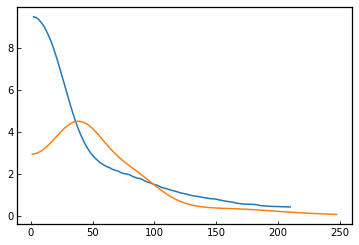

In [ ]:
f,ax = subplots(1)
fwhm = fwhm_list[j]
pa = pa_list[j]
im = rpy.image.readImage()
imc = im.imConv(dpc=GMaur_params['dpc'],fwhm=fwhm,pa=pa)
noise = obs_params['noise'][j]
xau, yau, im_mjy = snu_units(imc,dpc=GMaur_params['dpc'])
ax.set_facecolor('black')
im=ax.pcolormesh(xau, yau, im_mjy,cmap='magma')
colorbar(im)
#xlim(-0.5,0.5)
#ylim(-0.5,0.5)
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)
#rpy.image.plotImage(im,au=True,log=True, dpc=GMaur_params['dpc'],bunit='norm',cmap='magma',fig=f)
#rpy.image.plotImage(imc,arcsec=True,dpc=GMaur_params['dpc'],log=False,bunit='jy/beam',cmap='magma',fig=f)

In [18]:
os.chdir(mtest.m.outdir)
data_header = np.loadtxt('GM_Aur_cont.txt',max_rows=1,dtype=str)[::2]
data = np.loadtxt('GM_Aur_cont.txt',skiprows=1).T
gma_data = dict(zip(data_header,data))
for keys in gma_data.keys():
    print(keys)

R
I100
dI100
I150
dI150
I226
dI226
I257
dI257
I283
dI283


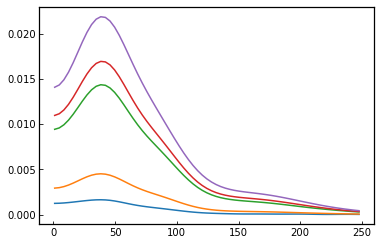

In [19]:
freqs = ['I100','I150','I226','I257','I283']
for freq in freqs:
    data = gma_data[freq]
    err = gma_data['d'+freq]
    Imax = np.amax(data)
    plot(gma_data['R'],data)

In [13]:
def Tdust_iter(output):
    T3D = output.T3D().swapaxes(0,1)
    model = output.m
    R,Z = model.make_rz()
    if output.T0 == {}:
        output.T0['i'] = model.T(R)
    if output.H0 == {}:
        output.H0['gas'] = model.H(R)
        output.H0['dust1'] = model.H(R,fluid=1)
        output.H0['dust2'] = model.H(R,fluid=2)
    Tfac = T3D/output.T0['i']
    Hi = output.H0['gas']
    nz = len(model.theta) - int((pi/2 - np.median(arctan(R[-1,:,0]/Hi[-1,:,0])))/np.median(np.gradient(model.theta)))
    nr = np.arange(0,len(model.r),1) + (np.diff(R[:,:,0],axis=0)[-1,:]/np.gradient(model.r)).astype(int)
    Tfac[R>model.disk['Rdisk'][0]] = 1.
    Tfac_midplane =  np.average(Tfac[nz:,nr,:],axis=0)
    Tfac_ave = np.average(Tfac_midplane,axis=-1)
    Tfunc = interpolate.interp1d(model.r,Tfac_ave.squeeze(),fill_value='extrapolate')
    return Tfunc

def iterate_rhoH(output):
    model = output.m
    R,Z = model.make_rz()
    Tfunc = Tdust_iter(output)
    print(np.average(Tfunc(R)))
    for fluid, i in zip(['gas','dust1','dust2'],[0,1,2]):
        Hi = output.H0[fluid].copy()
        Hip = Hi*np.sqrt(Tfunc(R))
        olddisk_rho = model.rho_disk(fluid=i).copy()
        newdisk_rho = olddisk_rho*np.sqrt(Hi/Hip)*np.exp(-0.5*(Z/Hip)**2)/np.exp(-0.5*(Z/Hi)**2)
        model.disk['hydro'][i] = newdisk_rho
        output.H0[fluid] = Hip

mtest.H0 = {}
mtest.T0 = {}
iterate_rhoH(mtest)


Reading dust_temperature.dat
1.1533930382588853
